# Algorytm k średnich (centroidów) - część II

15 grudzień 2017

#### Wstęp

W części pierwszej udało nam się podzielić dane na 4 klastry wg osoby kierującej pojazdem. W tej części spróbujemy rozpoznać kierunek w jakim patrzy kierowca czyli naszym celem będzie przewidzenie podziału wg. kolumny label. Aby to jednak było możliwe musimy arbitralnie wybrać osobę którą będziemy rozpatrywać.

Prezentowany materiał zakłada znajomość podstaw pythona i statystyki.


#### Narzędzia

Do budowy modelu, analizy i prezentacji wyników użyty zostanie pakiet narzędzi scikit-learn, numpy, pandas oraz matplotlib.

*Importujemy wszystkie potrzebne biblioteki*

In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.vq import kmeans
from scipy.spatial.distance import cdist,pdist
from sklearn import datasets
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.metrics.pairwise import pairwise_distances_argmin

import seaborn as sns

*Dane wejściowe pochodzą ze zbioru danych UCI (https://archive.ics.uci.edu/ml/datasets/DrivFace) i zawierają sekwencję obrazów 4 kierowców (zmienna subject) w realnych sytuacjach drogowych z klasyfikacją kierunku w jakim kierowca spogląda (lewo/na wprost/prawo) (zmienna label). Jest to ten sam zbiór danych co w części pierwszej. Jednak tym razem musimy zawęzić dane wejściowe do jednej osoby - w naszym przypadku będzie to osoba nr 2*

In [2]:
# Load CSV and columns
df = pd.read_csv("drivPoints.txt")

df = df[df['subject']==2]

df.head(n=5)

,fileName,subject,imgNum,label,ang,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM
179,20130529_02_Driv_001_f,2,1,2,15,306,161,111,125,347,187,396,189,380,210,361,237,390,237
180,20130529_02_Driv_002_f,2,2,2,15,315,164,101,122,347,187,394,189,381,209,357,240,390,240
181,20130529_02_Driv_003_f,2,3,2,15,304,164,112,127,344,189,391,190,378,209,356,241,387,242
182,20130529_02_Driv_004_f,2,4,2,15,301,166,112,128,341,192,393,194,377,213,356,244,384,243
183,20130529_02_Driv_005_f,2,5,2,15,300,168,118,125,341,193,388,194,377,215,354,246,384,247


*Przed dalszą analizą rzut oka na dane. Widzimy dużą dysproporcje w ilości danych dla kierunku "na wprost" - 146 obrazów i jednie 14 i 10 obrazów dla kierunku lewo/prawo*

In [3]:
df.groupby('label').describe()

ang                                                        hF  \
       count       mean       std   min   25%   50%   75%   max  count   
label                                                                    
1       14.0 -36.428571  7.703289 -45.0 -45.0 -30.0 -30.0 -30.0   14.0   
2      146.0   7.808219  8.669658 -15.0   0.0  15.0  15.0  15.0  146.0   
3       10.0  36.000000  7.745967  30.0  30.0  30.0  45.0  45.0   10.0   

                   ...       yRE           yRM                               \
             mean  ...       75%    max  count        mean       std    min   
label              ...                                                        
1      134.071429  ...    186.75  189.0   14.0  234.785714  2.913591  229.0   
2      130.013699  ...    202.00  214.0  146.0  241.390411  9.774261  221.0   
3      139.400000  ...    185.75  195.0   10.0  233.800000  3.425395  229.0   

                                     
          25%    50%     75%    max  
label                                
1      233.25  235.5  236.75  239.0  
2      233.25  241.0  250.00  262.0  
3      232.00  234.5  235.00  240.0  

[3 rows x 136 columns]

*Wybieramy dane na podstawie których algorytm będzie tworzył grupy. Są to te same dane co w części pierwszej*

In [4]:
X = df[['ang','xF','yF','wF','hF','xRE','yRE','xLE','yLE','xN','yN','xRM','yRM','xLM','yLM']]
labels = df['label']
X = X.astype(float)

X.head()

,ang,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM
179,15.0,306.0,161.0,111.0,125.0,347.0,187.0,396.0,189.0,380.0,210.0,361.0,237.0,390.0,237.0
180,15.0,315.0,164.0,101.0,122.0,347.0,187.0,394.0,189.0,381.0,209.0,357.0,240.0,390.0,240.0
181,15.0,304.0,164.0,112.0,127.0,344.0,189.0,391.0,190.0,378.0,209.0,356.0,241.0,387.0,242.0
182,15.0,301.0,166.0,112.0,128.0,341.0,192.0,393.0,194.0,377.0,213.0,356.0,244.0,384.0,243.0
183,15.0,300.0,168.0,118.0,125.0,341.0,193.0,388.0,194.0,377.0,215.0,354.0,246.0,384.0,247.0


*Przygotowujemy dane pod krzywą łokciową*

In [5]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist


K = range(1,10)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

*Ponieważ z góry znamy liczbę klastrów możemy od razu zapezentować ichliczbę na wykresie. Wykres pojawi się na końcu w zbiorczym, graficznym zestawieniu danych*

In [6]:
sns.set()
kIdx = 2
# plot elbow curve

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle('Super title', fontsize=16)

axs[0, 0].plot(K, avgWithinSS, 'b*-')
axs[0, 0].plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
axs[0, 0].grid(True)
axs[0, 0].set_xlabel('Number of clusters')
axs[0, 0].set_ylabel('Average sum of squares')
axs[0, 0].set_title('Elbow for K-Means clustering')

Text(0.5,1,'Elbow for K-Means clustering')

*Do celów prezentacji redukujemy liczbę wymiarów do 2. Widzimy, że redukcja nie spowodowała znaczącej utraty informacji. Ciągle dysponujemy 94% informacji wejściowych*

In [7]:
pca = PCA(n_components=2, svd_solver='randomized').fit(X)
X_2d = pca.transform(X)

explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 94%


*Na drugim wykresie prezentujemy dane rzeczywiste. Będziemy mogli w prosty sposób wizualnie ocenić jakość działania algorytmu*

In [8]:
axs[0, 1].scatter(X_2d[:,0], X_2d[:,1], c=labels, s=30, cmap=plt.cm.Paired)
#ax.colorbar()
axs[0, 1].set_xlabel('PC1')
axs[0, 1].set_ylabel('PC2')
axs[0, 1].set_title('Real Data')

#plt.show()

Text(0.5,1,'Real Data')

*Tworzymy model i wykonujemy podział. Liczbę klastrów ustawiamy na 3 (n_clusters=3)*

In [9]:
mbk = MiniBatchKMeans(n_clusters=3, init='k-means++', n_init=1,
                     init_size=1000, batch_size=1000, verbose=False)

labels_pred = mbk.fit_predict(X_2d)

*Przygotowujemy wizualizację danych po podziale na klastry*

In [10]:
axs[1, 0].scatter(X_2d[:,0], X_2d[:,1], c=labels_pred, s=20, cmap=plt.cm.Paired)
#plt.colorbar()
axs[1, 0].set_xlabel('PC1')
axs[1, 0].set_ylabel('PC2')
axs[1, 0].set_title('Predicted Data')

Text(0.5,1,'Predicted Data')

*Na ostatnim wykresie prezentujmy podział na klastry wraz z ich centroidami. Jak widzimy dane rzeczywiste i nasz podział różnia się od siebie zwłaszcza jeżeli chodzi o kierunki lewy/prawy dla których liczba danych była znacznie mniejsza*

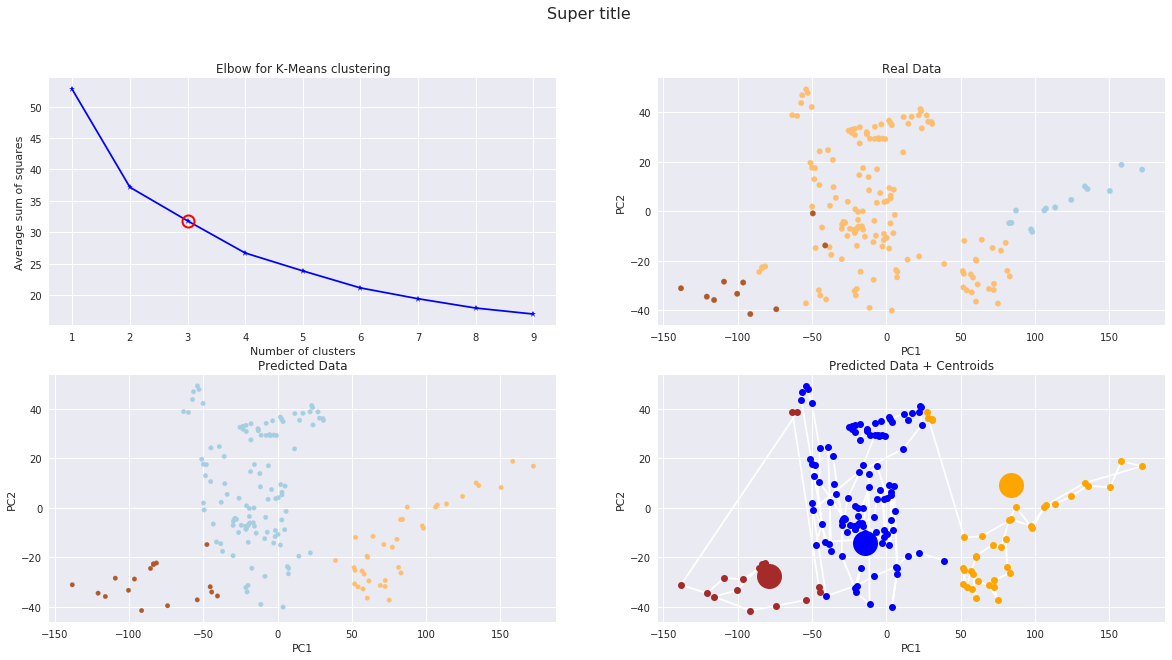

In [11]:
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis=0)
mbk_means_labels = pairwise_distances_argmin(X_2d, mbk_means_cluster_centers)

colors = ['brown', 'blue', 'orange']
n_clusters = 3

for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    axs[1, 1].plot(X_2d[my_members, 0], X_2d[my_members, 1], 'w', markerfacecolor=col, marker='o')
    axs[1, 1].plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=25)

axs[1, 1].set_xlabel('PC1')
axs[1, 1].set_ylabel('PC2')
axs[1, 1].set_title('Predicted Data + Centroids')


plt.show()

*Rzut oka na jednorodność (Homogeneity) i kompletność (Completeness) i widzimy, że nie jest to najlepsze klastrowanie. Niska kompletność wskazuje na mieszanie się klas co widzimy na rysunku 2 i 3.*

In [12]:
from sklearn import metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, mbk.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, mbk.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, mbk.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, mbk.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_2d, mbk.labels_, sample_size=1000))

print()

Homogeneity: 0.457
Completeness: 0.280
V-measure: 0.347
Adjusted Rand-Index: 0.362
Silhouette Coefficient: 0.510

